# Introduction

In this lab, we will be using the Ames Housing dataset to compare different methods of handling categorical features in Gradient Boosting estimators. The dataset contains both numerical and categorical features, and the target is the sales price of the houses. We will compare the performance of four different pipelines:

- Dropping the categorical features
- One-hot encoding the categorical features
- Treating the categorical features as ordinal values
- Using native categorical support in the Gradient Boosting estimator

We will evaluate the pipelines in terms of their fit times and prediction performances using cross-validation.

# Load the dataset

We will load the Ames Housing dataset using Scikit-Learn's fetch_openml function and select a subset of the features to make the example faster to run. We will also convert the categorical features to the 'category' dtype.

In [10]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml(data_id=42165, as_frame=True, return_X_y=True)

# Select only a subset of features of X to make the example faster to run
categorical_columns_subset = [
    "BldgType",
    "GarageFinish",
    "LotConfig",
    "Functional",
    "MasVnrType",
    "HouseStyle",
    "FireplaceQu",
    "ExterCond",
    "ExterQual",
    "PoolQC",
]

numerical_columns_subset = [
    "3SsnPorch",
    "Fireplaces",
    "BsmtHalfBath",
    "HalfBath",
    "GarageCars",
    "TotRmsAbvGrd",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "GrLivArea",
    "ScreenPorch",
]

X = X[categorical_columns_subset + numerical_columns_subset]
X[categorical_columns_subset] = X[categorical_columns_subset].astype("category")

categorical_columns = X.select_dtypes(include="category").columns
n_categorical_features = len(categorical_columns)
n_numerical_features = X.select_dtypes(include="number").shape[1]

print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of categorical features: {n_categorical_features}")
print(f"Number of numerical features: {n_numerical_features}")

Number of samples: 1460
Number of features: 20
Number of categorical features: 10
Number of numerical features: 10


# Baseline Pipeline - Drop Categorical Features

We will create a pipeline where we drop the categorical features and train a HistGradientBoostingRegressor estimator.

In [11]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline

dropper = make_column_transformer(
    ("drop", make_column_selector(dtype_include="category")), remainder="passthrough"
)
hist_dropped = make_pipeline(dropper, HistGradientBoostingRegressor(random_state=42))

# One-hot Encoding Pipeline

We will create a pipeline where we one-hot encode the categorical features and train a HistGradientBoostingRegressor estimator.

In [12]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
)

hist_one_hot = make_pipeline(
    one_hot_encoder, HistGradientBoostingRegressor(random_state=42)
)

# Ordinal Encoding Pipeline

We will create a pipeline where we treat the categorical features as ordinal values and train a HistGradientBoostingRegressor estimator. We will use an OrdinalEncoder to encode the categorical features.

In [13]:
import numpy as np

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
    # Use short feature names to make it easier to specify the categorical
    # variables in the HistGradientBoostingRegressor in the next step
    # of the pipeline.
    verbose_feature_names_out=False,
)

hist_ordinal = make_pipeline(
    ordinal_encoder, HistGradientBoostingRegressor(random_state=42)
)

# Native Categorical Support Pipeline

We will create a pipeline where we use the native categorical support of the HistGradientBoostingRegressor estimator to handle categorical features. We will still use an OrdinalEncoder to pre-process the data.

In [14]:
hist_native = HistGradientBoostingRegressor(
    random_state=42, categorical_features="from_dtype"
)

# Model Comparison

We will compare the performance of the four pipelines using cross-validation and plot the fit times and mean absolute percentage error scores.

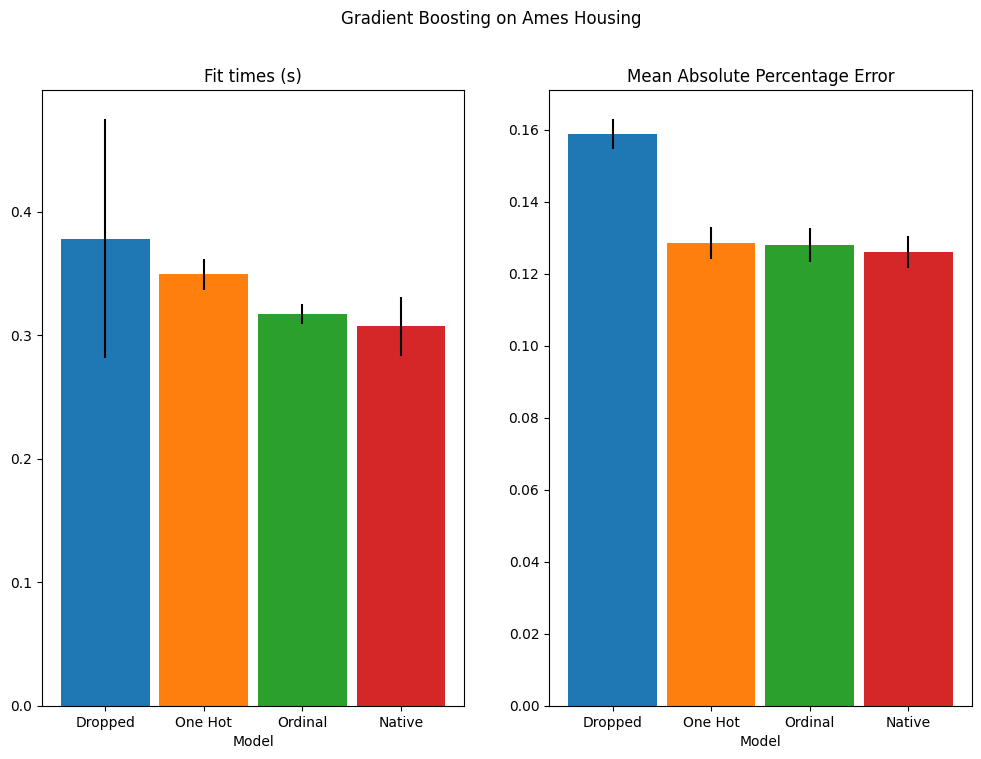

In [15]:
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate

scoring = "neg_mean_absolute_percentage_error"
n_cv_folds = 3

dropped_result = cross_validate(hist_dropped, X, y, cv=n_cv_folds, scoring=scoring)
one_hot_result = cross_validate(hist_one_hot, X, y, cv=n_cv_folds, scoring=scoring)
ordinal_result = cross_validate(hist_ordinal, X, y, cv=n_cv_folds, scoring=scoring)
native_result = cross_validate(hist_native, X, y, cv=n_cv_folds, scoring=scoring)


def plot_results(figure_title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    plot_info = [
        ("fit_time", "Fit times (s)", ax1, None),
        ("test_score", "Mean Absolute Percentage Error", ax2, None),
    ]

    x, width = np.arange(4), 0.9
    for key, title, ax, y_limit in plot_info:
        items = [
            dropped_result[key],
            one_hot_result[key],
            ordinal_result[key],
            native_result[key],
        ]

        mape_cv_mean = [np.mean(np.abs(item)) for item in items]
        mape_cv_std = [np.std(item) for item in items]

        ax.bar(
            x=x,
            height=mape_cv_mean,
            width=width,
            yerr=mape_cv_std,
            color=["C0", "C1", "C2", "C3"],
        )
        ax.set(
            xlabel="Model",
            title=title,
            xticks=x,
            xticklabels=["Dropped", "One Hot", "Ordinal", "Native"],
            ylim=y_limit,
        )
    fig.suptitle(figure_title)


plot_results("Gradient Boosting on Ames Housing")

# Limiting the Number of Splits

We will re-run the same analysis with under-fitting models where we artificially limit the total number of splits by both limiting the number of trees and the depth of each tree.

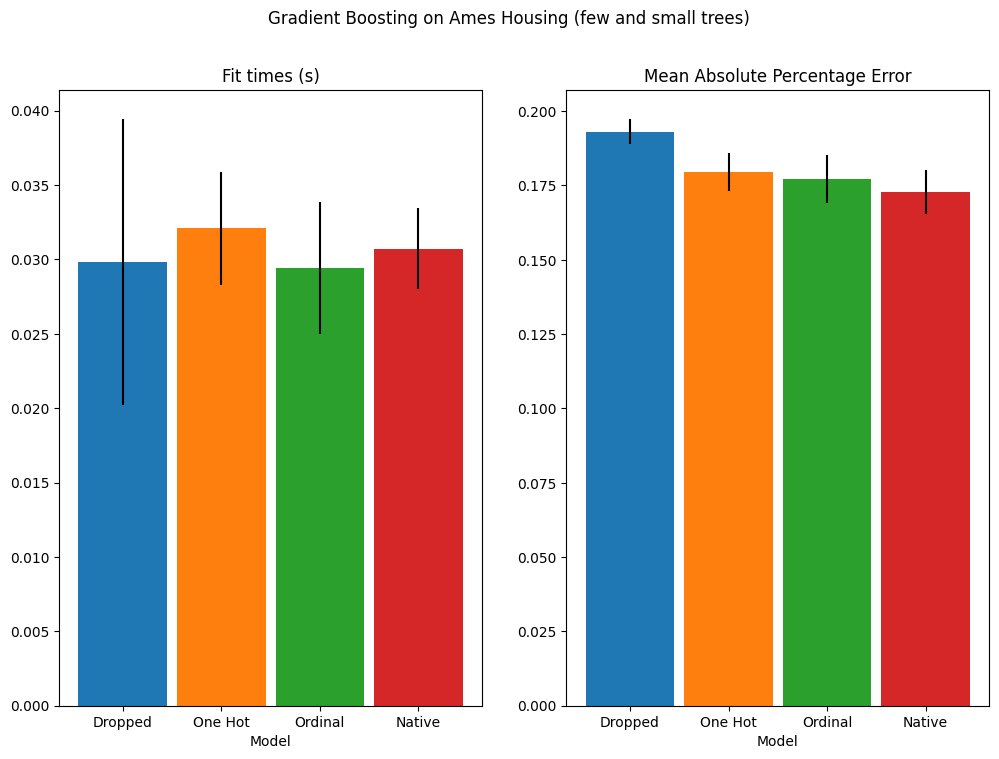

In [18]:
for pipe in (hist_dropped, hist_one_hot, hist_ordinal, hist_native):
    if pipe is hist_native:
        # The native model does not use a pipeline so, we can set the parameters
        # directly.
        pipe.set_params(max_depth=3, max_iter=15)
    else:
        pipe.set_params(
            histgradientboostingregressor__max_depth=3,
            histgradientboostingregressor__max_iter=15,
        )

dropped_result = cross_validate(hist_dropped, X, y, cv=n_cv_folds, scoring=scoring)
one_hot_result = cross_validate(hist_one_hot, X, y, cv=n_cv_folds, scoring=scoring)
ordinal_result = cross_validate(hist_ordinal, X, y, cv=n_cv_folds, scoring=scoring)
native_result = cross_validate(hist_native, X, y, cv=n_cv_folds, scoring=scoring)

plot_results("Gradient Boosting on Ames Housing (few and small trees)")

plt.show()

# Summary

In this lab, we compared four different pipelines for handling categorical features in Gradient Boosting estimators using the Ames Housing dataset. We found that dropping categorical features led to poorer prediction performance, and that the three models that used categorical features had comparable error rates. One-hot encoding the categorical features was by far the slowest method, while treating the categorical features as ordinal values and using the native categorical support of the HistGradientBoostingRegressor estimator had similar fit times. When the total number of splits was limited, the native categorical support strategy performed the best.
